<a href="https://colab.research.google.com/github/CedricFont/Deep-learning-for-autonomous-vehicle/blob/develop/Final_project/Tests_for_pose_estimation/Pose_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from google.colab import drive
from google.colab import files
import cv2
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

In [19]:
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
! git clone https://github.com/spmallick/learnopencv.git

Cloning into 'learnopencv'...
remote: Enumerating objects: 10125, done.
remote: Counting objects: 100% (917/917), done.
remote: Compressing objects: 100% (573/573), done.
remote: Total 10125 (delta 337), reused 864 (delta 319), pack-reused 9208
Receiving objects: 100% (10125/10125), 1.12 GiB | 32.34 MiB/s, done.
Resolving deltas: 100% (3014/3014), done.
Checking out files: 100% (4478/4478), done.


In [28]:
%ls -a
%cd ..
%ls -a
%cd /content/drive/MyDrive/Colab_Notebooks
%ls -a

.file-revisions-by-id/  Shareddrives/             .Trash-0/
MyDrive/                .shortcut-targets-by-id/
/content
./  ../  .config/  drive/  learnopencv/  sample_data/
/content/drive/MyDrive/Colab_Notebooks
11_Panda_robot_identification.ipynb
CNN_pytorch_3_2_10_epochs.ckpt
CNN_pytorch_3_2.ckpt
CNN_pytorch.ckpt
getModels.sh
graph_opt.pb
image.jpg
linearClassifier_pytorch.ckpt
pose_deploy_linevec_faster_4_stages.prototxt
pose_deploy_linevec.prototxt
pose_iter_160000.caffemodel
Softmax.ipynb
softmax_weights.pkl
Untitled0.ipynb
Untitled1.ipynb


In [38]:
!cp -c "/content/drive/MyDrive/Colab_Notebooks/pose_iter_160000.caffemodel" -P "/pose/mpi"

cp: invalid option -- 'c'
Try 'cp --help' for more information.


In [8]:
% cd learnopencv/OpenPose
! ls -a

/content/learnopencv/OpenPose
.		.ipynb_checkpoints  OpenPose_Notebook.ipynb  README.md
..		multiple.jpeg	    OpenPoseVideo.cpp	     sample_video.mp4
CMakeLists.txt	OpenPoseImage.cpp   OpenPoseVideo.py	     single.jpeg
getModels.sh	OpenPoseImage.py    pose


In [9]:
!sudo chmod a+x getModels.sh

In [17]:
%ls -a
%cd learnopencv/OpenPose

./   .bashrc*  .config/  .ipython/  .keras/  .npm/     .ssh/
../  .cache/   .gsutil/  .jupyter/  .local/  .profile  .tmux.conf*
[Errno 2] No such file or directory: 'learnopencv/OpenPose'
/root


In [40]:
# Specify the paths for the 2 files
protoFile = "/content/drive/MyDrive/Colab_Notebooks/pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "/content/drive/MyDrive/Colab_Notebooks/pose_iter_160000.caffemodel"

# Read the network into Memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)


In [48]:
%cd /.
%ls -a
%cd /content/learnopencv/OpenPose
%ls -a

/
./     content/     etc/    lib64/  proc/        sbin/               tmp/
../    datalab/     home/   media/  python-apt/  srv/                tools/
bin/   dev/         lib/    mnt/    root/        sys/                usr/
boot/  .dockerenv*  lib32/  opt/    run/         tensorflow-1.15.2/  var/
/content/learnopencv/OpenPose
./              .ipynb_checkpoints/  OpenPose_Notebook.ipynb  README.md
../             multiple.jpeg        OpenPoseVideo.cpp        sample_video.mp4
CMakeLists.txt  OpenPoseImage.cpp    OpenPoseVideo.py         single.jpeg
getModels.sh*   OpenPoseImage.py     pose/


In [49]:
%ls -a

./              .ipynb_checkpoints/  OpenPose_Notebook.ipynb  README.md
../             multiple.jpeg        OpenPoseVideo.cpp        sample_video.mp4
CMakeLists.txt  OpenPoseImage.cpp    OpenPoseVideo.py         single.jpeg
getModels.sh*   OpenPoseImage.py     pose/


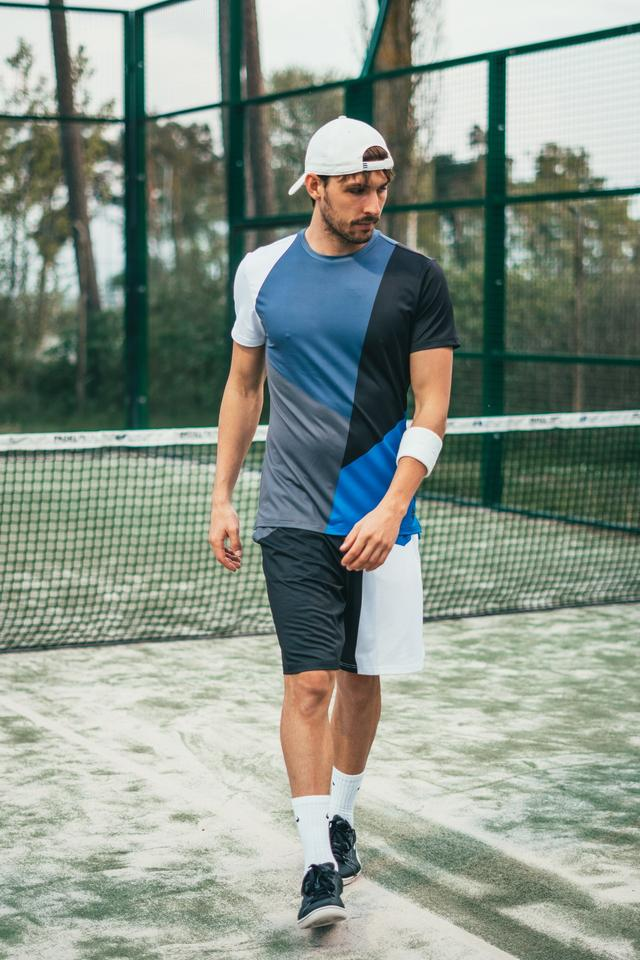

In [62]:
# Read image
frame = cv2.imread("/content/learnopencv/OpenPose/single.jpeg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1
display(Image(filename='/content/learnopencv/OpenPose/single.jpeg')) 

# Specify the input image dimensions
inWidth = 368
inHeight = 368

# Prepare the frame to be fed to the network
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight), (0, 0, 0), swapRB=False, crop=False)

# Set the prepared object as the input blob of the network
net.setInput(inpBlob)


In [58]:
output = net.forward()

In [65]:
MODE = 'MPI'

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

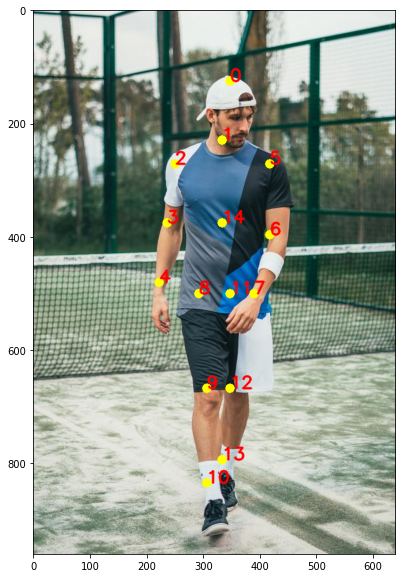

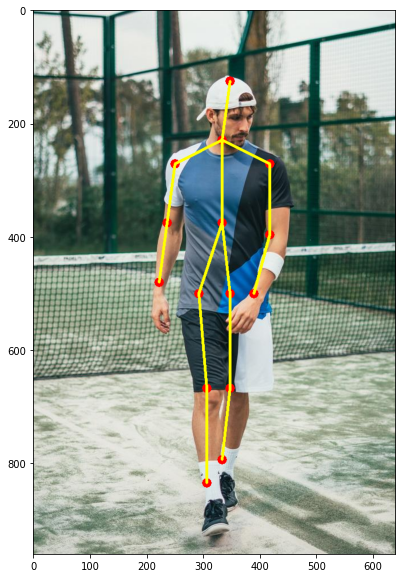

In [69]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))